## How FDSP control is affected by the presence of FDSP produced by Coma (Z7, Z8)

In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline
import scipy.io as sio

### Initialization of GMT, GS, WFS, PS, ...

pupil sampling: 469 pixel
SH Pixel scale: 0.132arcsec
SH Field of view: 2.376arcsec


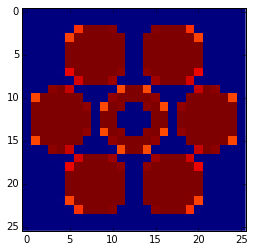

In [2]:
# Telescope parameters
D = 26.
nPx = 469
radial_order = 4
n_zern = (radial_order+1)*(radial_order+2)/2
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

# Initialize on-axis star for performance evaluation
ongs = ceo.Source("I",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# number of SH WFS Guide Stars and position
N_GS = 1
if N_GS > 1:
    alpha =6*60.  # radius of circle where GSs are located [in arcsec]
    zenith_angle  = np.ones(N_GS)*alpha*math.pi/180/3600 # in radians
    azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
else:
    alpha = 0.
    zenith_angle = 0.
    azimuth_angle = 0.
    
# GS for SH wavefront sensing
gs = ceo.Source("R",zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# SH WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 18         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=N_GS)

# Calibrate WFS slope null vector
gs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(gs)
wfs.calibrate(gs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet*N_GS,nLenslet)).T,interpolation='none')

print "pupil sampling: %d pixel"%nPx
print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "SH Field of view: %.3farcsec"%(sh_fov)

In [3]:
# Dispersed Fringe Sensors
N_GS_PS = 3
alpha_ps =6*60.  # radius of circle where GSs are located [in arcsec]
zenith_angle_ps  = np.ones(N_GS_PS)*alpha_ps*math.pi/180/3600 # in radians
azimuth_angle_ps = np.arange(N_GS_PS)*360.0/N_GS_PS # in degrees
gsps = ceo.Source("R",zenith=zenith_angle_ps,azimuth=azimuth_angle_ps*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
ps = ceo.DispersedFringeSensor(gmt.M1,gsps)#,nyquist_factor=2)
ps.calibrate(gsps,gmt)
ps.reset()

<matplotlib.colorbar.Colorbar instance at 0x2ae5f5447908>

/home/ubuntu/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


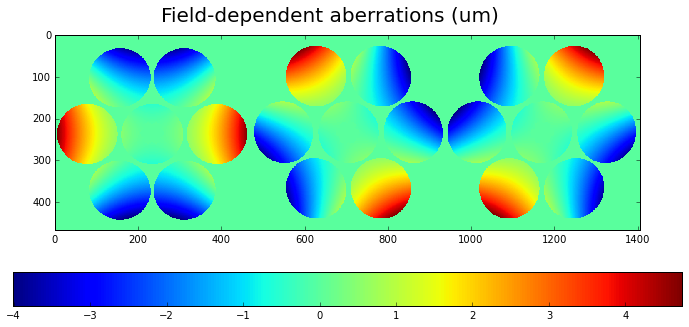

In [4]:
# Calibrate SPS reference vector (corresponding to field-dependent aberrations)
gsps.reset()
gmt.reset()
gmt.propagate(gsps)
ph_fda = gsps.phase.host(units='micron').T
SPSmeas_ref = ps.piston(gsps, segment='edge')#, edge_tilt_fitted=True)
#print np.array_str(SPSmeas_ref*1e9, precision=4, suppress_small=True)
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations (um)', fontsize=20)
imm = ax.imshow(ph_fda, interpolation='None')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

### Initialization of on-axis performance evaluation and projection of segments onto Zernikes

<matplotlib.colorbar.Colorbar instance at 0x2ae5f6374f38>

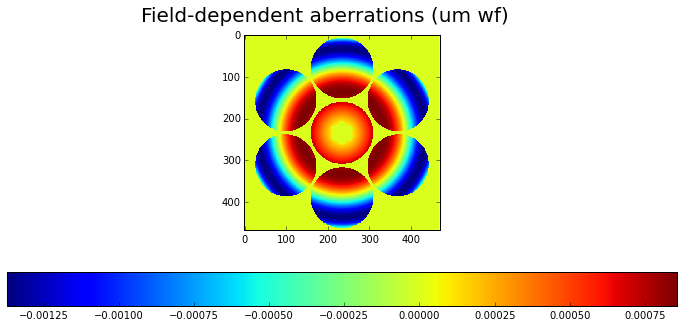

In [5]:
#Get on-axis residual WF solely due to telescope aberrations when perfectly aligned
ongs.reset()
gmt.reset()
gmt.propagate(ongs)
Wref = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)

ph_fda_on = ongs.phase.host(units='micron')
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
imm = ax.imshow(ph_fda_on, interpolation='None')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

In [6]:
#### Define $\rho$ and $\theta$ coordinates on each mirror segment mask (on-axis direction)
Zobj = ceo.ZernikeS(radial_order)
P = np.rollaxis( np.array( ongs.rays.piston_mask ),0,3)

## Find center coordinates (in pixels) of each segment mask
u = np.arange(ongs.n)
v = np.arange(ongs.m)
x,y = np.meshgrid(u,v)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P,axis=1)/P.sum(axis=1)
yc = np.sum(y*P,axis=1)/P.sum(axis=1)
#plt.plot(alpha_off/60,xc[(0,3,6),:].T,'-+')

## Preliminary estimation of radius (in pixels) of each segment mask (assuming that there is no central obscuration)
Rs = np.sqrt(P.sum(axis=1)/np.pi)

## Polar coordinates
rho   = np.hypot(   x - xc[:,np.newaxis,:], y - yc[:,np.newaxis,:])   #temporal rho vector
theta = np.arctan2( y - yc[:,np.newaxis,:], x - xc[:,np.newaxis,:]) * P

## Estimate central obscuration area of each segment mask
ObsArea = np.sum(rho < 0.9*Rs[:,np.newaxis,:] * ~P.astype('bool'), axis=1)

## Improve estimation of radius of each segment mask
Rs = np.sqrt( (P.sum(axis=1)+ObsArea) / np.pi)

## Normalize rho vector (unitary radius)
rho = rho / Rs[:,np.newaxis,:] * P #final rho vector

In [7]:
# Build an Zernike Influence-function Matrix for all segments (ON-AXIS direction)
alphaId = 0   # only on-axis direction supported...

Zmat = np.zeros((nPx*nPx,Zobj.n_mode,7))
for segId in range(1,8):
    Zobj.reset()
    cutheta = ceo.cuDoubleArray(host_data=theta[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
    curho   = ceo.cuDoubleArray(host_data=  rho[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
    for k in range(Zobj.n_mode):
        Zobj.a[0,k] = 1
        Zobj.update()
        S = Zobj.surface(curho,cutheta).host(shape=(nPx*nPx,1))*P[segId-1,:,alphaId].reshape(-1,1)
        Zmat[:,k,segId-1] = S.flatten()
        Zobj.a[0,k] = 0

print Zmat.shape

(219961, 15, 7)


In [8]:
#Pseudo-inverse of Zmat
invZmat = np.zeros((Zobj.n_mode,nPx*nPx,7))
for segId in range(1,8):
    invZmat[:,:,segId-1] = np.linalg.pinv(Zmat[:,:,segId-1])
print invZmat.shape

(15, 219961, 7)


In [9]:
#Compute the rms over each segment
def segment_rms(WF, P):
    rms_seg = np.sqrt(np.sum((WF[np.newaxis,:,np.newaxis]*P)**2,axis=1)/P.sum(axis=1))
    return rms_seg

### Interaction and Reconstruction matrices

In [10]:
# Calibrate M2 segment TT Interaction Matrix and Reconstructor
TTstroke = 25e-3 #arcsec
gmt.reset()
D_M2_TT = gmt.calibrate(wfs, gs, mirror="M2", mode="segment tip-tilt", stroke=TTstroke*math.pi/180/3600)
R_M2_TT = np.linalg.pinv(D_M2_TT)
R_M2_TT.shape

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


(14, 624)

___ M2 ___
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
(624, 84)


<matplotlib.colorbar.Colorbar instance at 0x2ae5f7e003b0>

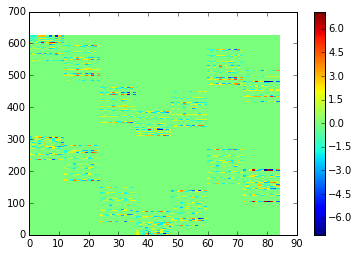

In [11]:
# Calibrate M2 segment Zernikes Interaction Matrix with SH WFS
# NOTE:  GMTILB.PY  modified to include TT in Zernikes !!!!

Zstroke = 50e-9 #m rms
D_M2_Z = gmt.calibrate(wfs, gs, mirror="M2", mode="zernike", stroke=Zstroke, first_mode=1)

#remove TT (Z2 & Z3) from IM
D_M2_Z = ((D_M2_Z.reshape(-1,7,n_zern-1))[:,:,2:]).reshape(-1,(n_zern-3)*7)
nzernall = (D_M2_Z.shape)[1]  ## number of zernike DoFs calibrated
print D_M2_Z.shape

plt.pcolor(D_M2_Z)
plt.colorbar()

In [12]:
R_M2_Z = np.linalg.pinv(D_M2_Z)
print R_M2_Z.shape
print np.linalg.cond(D_M2_Z)

(84, 624)
3.30832482298


In [13]:
# Calibrate Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m
D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston", stroke=PSstroke, segment='edge')

R_M1_PS = np.linalg.pinv(D_M1_PS)
R_M1_PS.shape

___ M1 ___
Segment #:1 2 3 4 5 6 
------------


(6, 36)

<matplotlib.colorbar.Colorbar instance at 0x2ae5f7e9fe60>

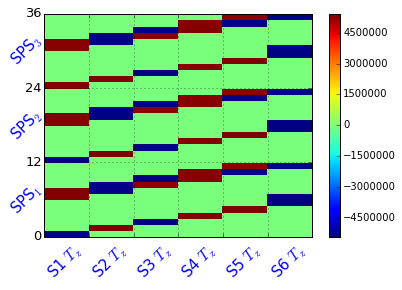

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)

imm = ax.pcolor(D_M1_PS)
ax.grid()
ax.set_ylim([0,36])
ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left', fontsize=15, rotation=45, color='b')
ax.set_yticks([0,12,24,36])
ax.tick_params(axis='y', labelsize=13)
ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
ax.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
ax.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
fig.colorbar(imm)

In [15]:
# Calibrate FDSP Interaction Matrix and Reconstructor
TTstroke = 50e-3 #arcsec
gmt.reset()
D_FDSP = gmt.calibrate(ps, gsps, mirror="M1", mode="FDSP", stroke=TTstroke*math.pi/180/3600, segment='edge', agws=wfs, recmat=R_M2_TT)
R_FDSP = np.linalg.pinv(D_FDSP)
R_FDSP.shape

___ M1 ___
Segment #:1 2 3 4 5 6 
------------


(12, 36)

<matplotlib.colorbar.Colorbar instance at 0x2ae61a2160e0>

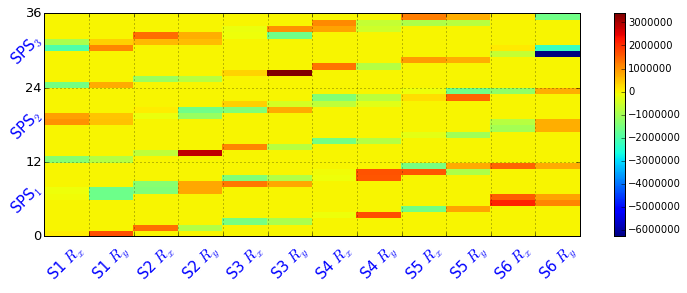

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(12,4)

imm = ax.pcolor(D_FDSP)
ax.grid()
ax.set_ylim([0,36])
ax.set_xticks(range(12))
ax.set_xticklabels(['S1 $R_x$','S1 $R_y$','S2 $R_x$','S2 $R_y$','S3 $R_x$','S3 $R_y$',
                    'S4 $R_x$','S4 $R_y$','S5 $R_x$','S5 $R_y$','S6 $R_x$','S6 $R_y$'],
                   ha='left', fontsize=15, rotation=45, color='b')
ax.set_yticks([0,12,24,36])
ax.tick_params(axis='y', labelsize=13)
ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
ax.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
ax.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
fig.colorbar(imm)

(18, 36)


<matplotlib.colorbar.Colorbar instance at 0x2ae61a3c0248>

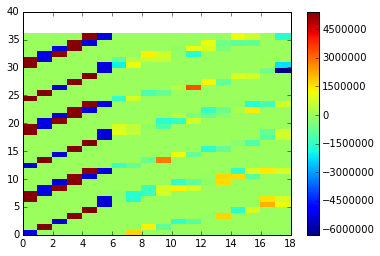

In [17]:
##### Combine Interaction Matrices of M1 segment piston AND FDSP.
D_PIST = np.concatenate((D_M1_PS, D_FDSP), axis=1)
R_PIST = np.linalg.pinv(D_PIST)
print R_PIST.shape
plt.pcolor(D_PIST)
plt.colorbar()

### Close loop correction with Brian's FDSP calibrations
The correction comprises:

1) segment tip-tilt
    - sensed with SH WFS
    - corrected on M2 with "fast" loop.

2) FDSP
    - sensed with 3 SPS
    - corrected by applying segment tilts on M1

3) segment piston
    - sensed with 3 SPS
    - corection applied on M1

In [23]:
##### Reset before starting
gs.reset()
gsps.reset()
ongs.reset()
gmt.reset()

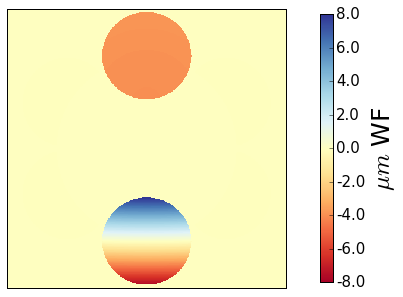

In [24]:
##### Apply a known Tilt to a particular segment on M1
M1RotVec = np.array([  #arcsec
            [200e-3,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   

##### Apply a known segment piston/translation to a particular segment on M1
M1TrVec = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,2e-6],
            [0,0,0],
            [0,0,0],
            [0,0,0]])

for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:].tolist(), euler_angles=M1RotVec[idx,:].tolist(), idx=idx+1)

##### Apply a known Tilt to a particular segment on M2
M2RotVec = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   

##### Apply a known segment piston/translation to a particular segment on M2
M2TrVec = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]])

for idx in range(7): gmt.M2.update(origin=M2TrVec[idx,:].tolist(), euler_angles=M2RotVec[idx,:].tolist(), idx=idx+1)    

# Apply a Zernike vector to a particular segment on M1
mysegId = 2
aidx = np.arange(0,n_zern)
a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
a_M1[1] = 500e-9      # m RMS surf
#gmt.M1.zernike.a[mysegId-1,:] = a_M1
#gmt.M1.zernike.update()

ongs.reset()
gmt.propagate(ongs)

fig, ax = plt.subplots()
fig.set_size_inches(20,5)
imm = ax.imshow(ongs.phase.host(units='micron'), interpolation='None',cmap='RdYlBu', vmin=-8, vmax=8)
ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
clb.set_label('$\mu m$ WF', fontsize=25)
clb.ax.tick_params(labelsize=15)


#plt.imshow(ongs.phase.host(units='nm')-ph_fda_on,interpolation='None')


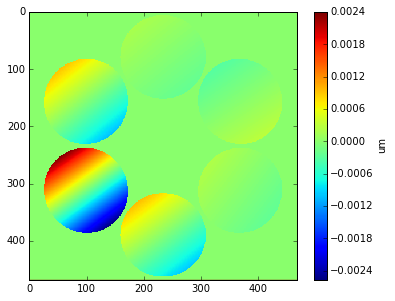

In [25]:
##### Close the loop !!!!!
f, ax = plt.subplots()
f.set_size_inches(6,8)
niter = 7
TTniter = 5

rmsval = np.zeros(niter*TTniter)
myTTest1 = np.zeros((7,2))
myPSest1 = np.zeros(6)
myFDSPest1 = np.zeros((6,2))  #6x M1 segment tip-tilt
a_M2 = np.zeros(nzernall)

for ii in range(niter):
    for jj in range(TTniter):
        ongs.reset()
        gmt.propagate(ongs)
        rmsval[ii*TTniter+jj] = ongs.wavefront.rms()
        #---- visualization
        if ii*TTniter+jj > 0: clb.remove()
        h = ax.imshow(ongs.phase.host(units='micron')-ph_fda_on,interpolation='None')
        clb = f.colorbar(h, ax=ax, shrink=0.6)
        clb.set_label('um')
        IPython.display.clear_output(wait=True)
        IPython.display.display(f)
        #---- segment TT correction
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.valid_slopes.host().ravel()
        myTTest1 += np.dot(R_M2_TT, slopevec).reshape((7,2))
        M2RotCor = np.zeros((7,3))
        M2RotCor[:,0:2] = myTTest1
        M2RotVec1 = M2RotVec - M2RotCor
        for idx in range(7): gmt.M2.update(origin=M2TrVec[idx,:].tolist(), euler_angles=M2RotVec1[idx,:].tolist(), idx=idx+1)
    
        ####### segment Zernikes correction (on M2)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.valid_slopes.host().ravel()
        a_M2 += np.dot(R_M2_Z, slopevec) 
        atemp = a_M2.reshape((7,-1))
        gmt.M2.zernike.a[:,3:] = -atemp
        gmt.M2.zernike.update()
    
    ####### FDSP and segment piston correction
    gsps.reset()
    gmt.propagate(gsps)
    ps.reset()
    PISTmeas = ps.piston(gsps, segment='edge') - SPSmeas_ref
    myPISTest1 = np.dot(R_PIST, PISTmeas.ravel())
    #--- segment piston
    myPSest1 += myPISTest1[0:6]
    M1TrCor = np.zeros((7,3))
    M1TrCor[0:6,2] = myPSest1
    M1TrVec1 = M1TrVec - M1TrCor
    #--- FDSP
    myFDSPest1 += myPISTest1[6:].reshape((6,2))
    M1RotCor = np.zeros((7,3))
    M1RotCor[0:6,0:2] = myFDSPest1
    M1RotVec1 = M1RotVec - M1RotCor    
    for idx in range(7): gmt.M1.update(origin=M1TrVec1[idx,:].tolist(), euler_angles=M1RotVec1[idx,:].tolist(), idx=idx+1)
    
    """
    ####### FDSP correction only
    gs.reset()
    gmt.propagate(gs)
    ps.reset()
    FDSPmeas = ps.piston(gs, segment='edge') - SPSmeas_ref
    myFDSPest1 += np.dot(R_FDSP, FDSPmeas.ravel()).reshape((6,2))
    M1RotCor = np.zeros((7,3))
    M1RotCor[0:6,0:2] = myFDSPest1
    M1RotVec1 = M1RotVec - M1RotCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:].tolist(), euler_angles=M1RotVec1[idx,:].tolist(), idx=idx+1)
      
    ####### segment Piston correction only
    gsps.reset()
    gmt.propagate(gsps)
    ps.reset()
    SPSmeas = ps.piston(gsps, segment='edge') - SPSmeas_ref
    myPSest1 += np.dot(R_M1_PS, SPSmeas.ravel())
    M1TrCor = np.zeros((7,3))
    M1TrCor[0:6,2] = myPSest1
    M1TrVec1 = M1TrVec - M1TrCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec1[idx,:].tolist(), euler_angles=M1RotVec[idx,:].tolist(), idx=idx+1)
    """
ongs.reset()
gmt.propagate(ongs)
Wres = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)

#---- visualization
clb.remove()
h = ax.imshow(ongs.phase.host(units='micron')-ph_fda_on,interpolation='None')
clb = f.colorbar(h, ax=ax, shrink=0.6)
clb.set_label('um')
IPython.display.clear_output(wait=True)
IPython.display.display(f)
plt.close()

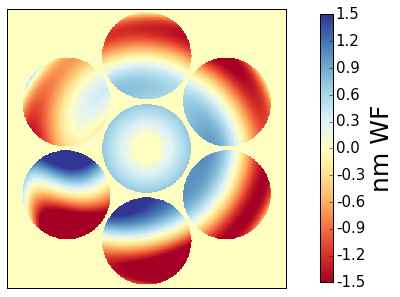

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
imm = ax.imshow(ongs.phase.host(units='nm'), interpolation='None',cmap='RdYlBu', vmin=-1.5, vmax=1.5)
ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
#clb.set_label('$\mu m$ WF', fontsize=25)
clb.set_label('nm WF', fontsize=25)
clb.ax.tick_params(labelsize=15)

M1 final piston (Tz) values [nm WF]:
[ 0.017  0.008  0.005  0.015  0.034  0.082  0.   ]
-----
M2 final piston (Tz) values [nm WF]:
[ 0.  0.  0.  0.  0.  0.  0.]


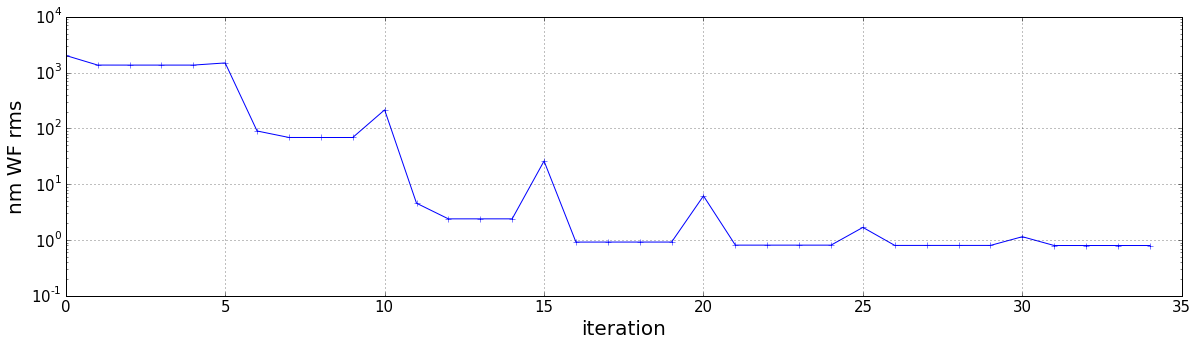

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)

ax.semilogy(rmsval*1e9, '-+')
ax.grid()
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('nm WF rms', fontsize=20)
ax.tick_params(labelsize=15)

print 'M1 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)
print '-----'
print 'M2 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)
#print 'segment tip-tilt on-axis estimation [mas]:'
#print np.array_str(myTTest1*180*3600/math.pi*1e3, precision=3, suppress_small=True)
#print 'segment piston estimation [nm]:'
#print np.array_str(myPSest1*1e9, precision=3,suppress_small=True)
#print 'M1 segment TT compensating for FDSP [mas]:'
#print np.array_str(myFDSPest1*180*3600/math.pi*1e3, precision=3, suppress_small=True)

In [ ]:
print '------> M1 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print '------> M2 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)

f1, (ax1,ax2) = plt.subplots(1,2)
f1.set_size_inches(14,4)

ax1.plot(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS,
         gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, '-o')
ax1.grid()
ax1.set_title('Rx', size='x-large')
ax1.set_xlabel('M2 segment tilt', size='large')
ax1.set_ylabel('M1 segment tilt', size='large')
ax2.plot(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS,
         gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, '-o')
ax2.grid()
ax2.set_title('Ry', size='x-large')
ax2.set_xlabel('M2 segment tilt', size='large')
ax2.set_ylabel('M1 segment tilt', size='large')

In [ ]:
rmsval*1e9

In [ ]:
#Project FD residuals onto Zernike modes
arec = np.zeros((Zobj.n_mode, 7))
for segId in range(1,8):
    arec[:,segId-1] = np.dot(invZmat[:,:,segId-1], (Wres-Wref)[:,:,alphaId].reshape(-1))

for segId in range(1,8):
    print 'segment #%d: -----------'%segId
    print np.array_str(arec[:,segId-1],precision=3,suppress_small=True)

In [ ]:
#rms over segment
WF = (ongs.phase.host(units='micron')-ph_fda_on).reshape(nPx*nPx)
print np.array_str(segment_rms(WF,P)*1e3, precision=3, suppress_small=True)  # in nm RMS WF

In [ ]:
print np.array_str(a_M1[3:]*1e9, precision=3, suppress_small=True)  # zernike coeffs [z4 onwards]
print np.array_str((1e9*a_M2.reshape((7,-1)))[mysegId-1,:], precision=3, suppress_small=True)  #Z4 onwards

In [ ]:
np.array_str(myPSest1*1e9,precision=3, suppress_small=True)